#### This assignment is a programming assignment wherein you have to build a multiple linear regression model for the prediction of demand for shared bikes.

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing required libs
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

In [3]:
#importing the dataset
bikedf = pd.read_csv("day.csv")
pd.options.display.max_columns = None

In [4]:
# Check the head of the dataset
bikedf.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Data Preparation

In [5]:
bikedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [6]:
# We dont need columns like 'dteday' and 'instant'. hence we can drop them straight away
bikedf.drop(['instant','dteday'], axis=1, inplace=True)

In [7]:
# Just for inspection
bikedf.sample(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
103,2,0,4,0,4,1,1,19.167500,23.13710,54.0417,7.416900,529,2738,3267
476,2,1,4,0,0,0,3,16.263347,19.47520,83.5417,23.084582,120,907,1027
353,4,0,12,0,2,1,2,15.819153,19.82270,59.5417,4.125244,216,3534,3750
120,2,0,5,0,0,0,2,18.518347,22.41020,76.2083,7.125718,1138,2213,3351
530,2,1,6,0,5,1,1,26.205847,29.98770,58.9583,11.833339,1563,6102,7665
501,2,1,5,0,4,1,1,24.326653,28.63065,52.0000,15.374825,1242,6142,7384
521,2,1,6,0,3,1,1,22.720847,27.11460,61.1250,5.167375,1027,6028,7055
122,2,0,5,0,2,1,2,25.283347,29.10395,69.7083,22.958689,603,3848,4451
236,3,0,8,0,4,1,2,28.050847,32.29270,77.1667,14.125811,435,3107,3542
525,2,1,6,0,0,0,1,29.793347,33.17585,53.8333,8.959307,2224,4374,6598


In [8]:
# Inspecting the shape of the dataset
bikedf.shape

(730, 14)

In [9]:
# Identifying the missing values in the dataset
# Missing values in bikedf dataframe in percentage.
round(100*(bikedf.isnull().sum()/len(bikedf.index)), 2)
# Good to see there are no missing values we need to treat here.

season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

In [10]:
# From the problem statement we need to understand the factors affecting the demand for these shared bikes. Hence 'cnt' 
# variable can be our target variable. Now this cnt is just addition of 'registered' and 'casual'. These two cannot be 
# independant variables on which our target variable depends. Hence we need to drop 'registered' and 'casual'

In [11]:
bikedf.drop(['casual','registered'], axis=1, inplace=True)

In [12]:
# Inspecting the variable weathersit
bikedf.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [13]:
# Inspecting the variable weekday
bikedf.weekday.value_counts()

6    105
1    105
0    105
5    104
4    104
2    104
3    103
Name: weekday, dtype: int64

In [14]:
# Inspecting the variable season
bikedf.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [15]:
# Inspecting the variable mnth
bikedf.mnth.value_counts()

12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     56
Name: mnth, dtype: int64

The above variables are categorical variables, and they are just integers, but after referring to the data dictionary, we
understand that we need to convert them into categorical variables.

### Handling the categorical variables as part of Data Preparation:

In [16]:
# First convert all supposed to be categorical variables to string 
bikedf['weekday'] = bikedf['weekday'].astype('str')
bikedf['season'] = bikedf['season'].astype('str')
bikedf['weathersit'] = bikedf['weathersit'].astype('str')
bikedf['mnth'] = bikedf['mnth'].astype('str')

# Taking care of weekday.  In the dataset they have added just the day of the week as a number. We need to convert this 
# into categorical variable. Checked the actual day on 01-01-2018 which was Monday and accordingly 6 is mapped to Monday and 
# so on.
bikedf['weekday'] = bikedf['weekday'].map({'0' :'Tues', '1' :'Wed', '2' : 'Thurs', '3' : "Fri", '4' : 'Sat', '5' : "Sun", '6': "Mon" })

bikedf['season'] = bikedf['season'].map({'1': 'spring', '2':'summer', '3':'fall', '4':'winter'})

bikedf['weathersit'] = bikedf['weathersit'].map({'1': 'clear', '2':'misty', '3':'light_snow_rain'})

bikedf['mnth'] = bikedf['mnth'].map({'1' :'Jan', '2' :'Feb', '3' : 'Mar', '4' : "Apr", '5' : 'May', '6' : "Jun", '7': "Jul",
                                    '8' : 'Aug', '9' : 'Sep', '10': 'Oct', '11' : 'Nov', '12': 'Dec'})

bikedf.sample(10) # Inspecting the dataframe with above categorical variable changes

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
424,spring,1,Mar,0,Sat,1,clear,19.919153,23.76855,61.5417,15.208129,4990
320,winter,0,Nov,0,Sat,1,misty,14.008347,16.16105,57.5833,20.459254,3053
190,fall,0,Jul,0,Tues,0,clear,30.647500,34.50125,57.8333,12.292557,4881
657,winter,1,Oct,0,Mon,0,clear,19.850847,23.64210,57.2917,7.874979,8090
322,winter,0,Nov,0,Mon,0,clear,13.495847,16.22415,50.2083,15.041232,3663
683,winter,1,Nov,0,Sat,1,misty,13.188347,16.22460,62.0417,10.250129,5445
498,summer,1,May,0,Wed,1,misty,23.506653,27.49500,78.9583,14.250364,2843
561,fall,1,Jul,0,Wed,1,clear,31.296653,36.20625,64.5000,11.000529,6830
351,winter,0,Dec,0,Tues,0,clear,9.771653,12.27895,58.6250,11.375193,2431
592,fall,1,Aug,0,Sat,1,clear,29.485847,32.73440,51.9167,9.500332,7605


### Visualising the Data

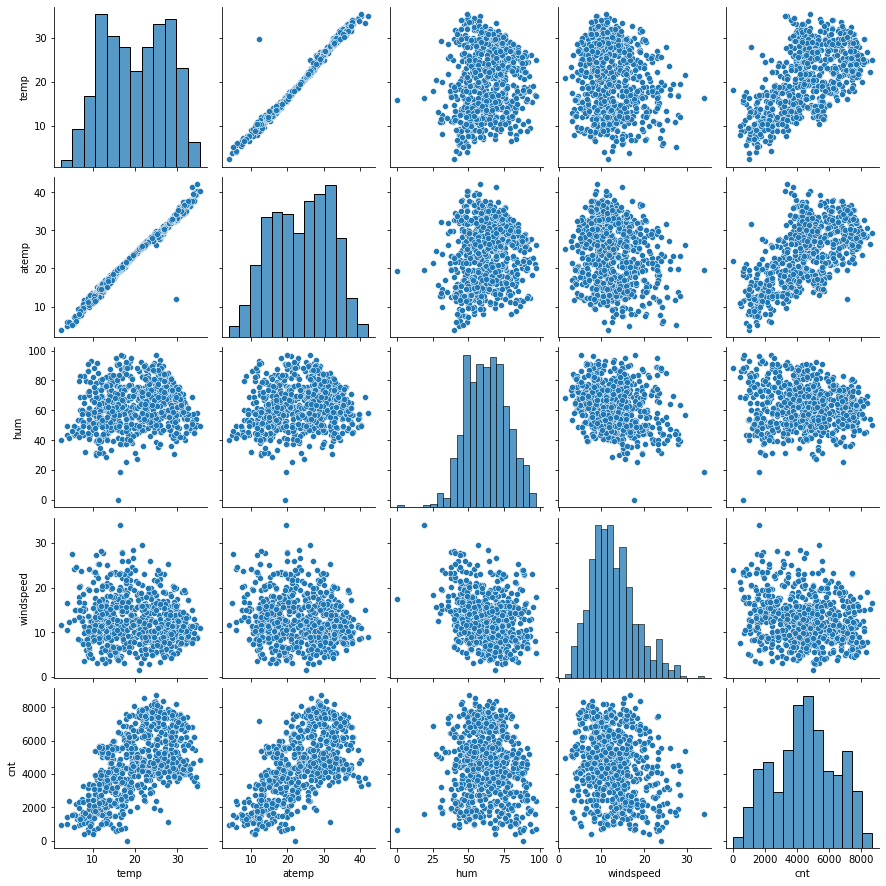

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns 
x_for_pair_plt = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(bikedf, x_vars= x_for_pair_plt, y_vars = x_for_pair_plt)
plt.show()

# pair plots for continuous variables.
# There seem to linear relation with the temp and atemp with out target variable cnt

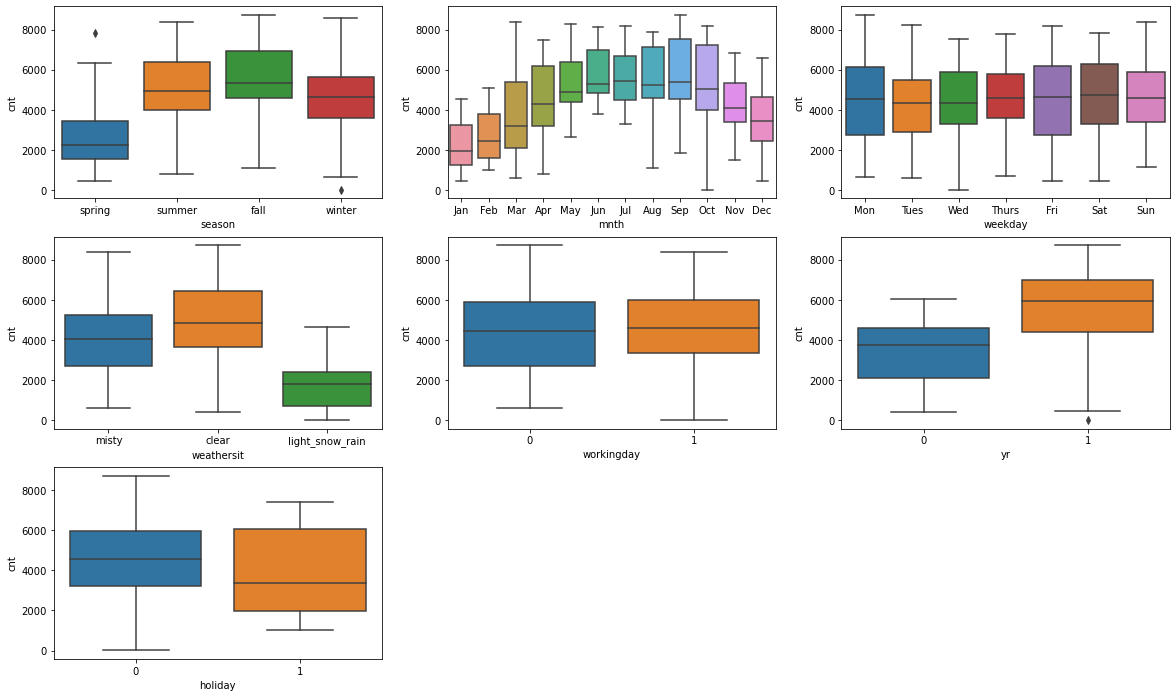

In [18]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bikedf)
plt.subplot(3,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = bikedf)
plt.subplot(3,3,3)
sns.boxplot(x = 'weekday', y = 'cnt', data = bikedf)
plt.subplot(3,3,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bikedf)
plt.subplot(3,3,5)
sns.boxplot(x = 'workingday', y = 'cnt', data = bikedf)
plt.subplot(3,3,6)
sns.boxplot(x = 'yr', y = 'cnt', data = bikedf)
plt.subplot(3,3,7)
sns.boxplot(x = 'holiday', y = 'cnt', data = bikedf)

plt.show()

# Below box plots for categorical variables indicate many things
# There is trend seen demand for mnths varaible. It goes on increasing from Jan to Sep and again starts dropping till Dec
# Indicative that demand is reduces during winters.
# Weekday and working day seems to be over all constant 
# Again summer, fall show higher demand, than spring and winter it is lower. Clearly we had seen trend between temp and demand
# The trend in season and demand is supporting it.
# Another important factor of yr is seen as demand is raised for 2019. It is said in problem statement that
# this is budding business and will grow with years. Hence demand in 2019 is higher than 2018.

# These insights from EDA will be helpful while we choose features along with the feature selection algorithm and criteria.

In [19]:
bikedf.shape # Just inspecting the shape

(730, 12)

In [20]:
# List comprehension to get columns with outliers.
from scipy import stats
from pandas.api.types import is_numeric_dtype
outliercolumns = []
outliercolumns = [col for col in bikedf if is_numeric_dtype(bikedf[col]) and (np.abs(stats.zscore(bikedf[col])) > 3).any()]

# Check columns with outliers.

print(outliercolumns)

['holiday', 'hum', 'windspeed']


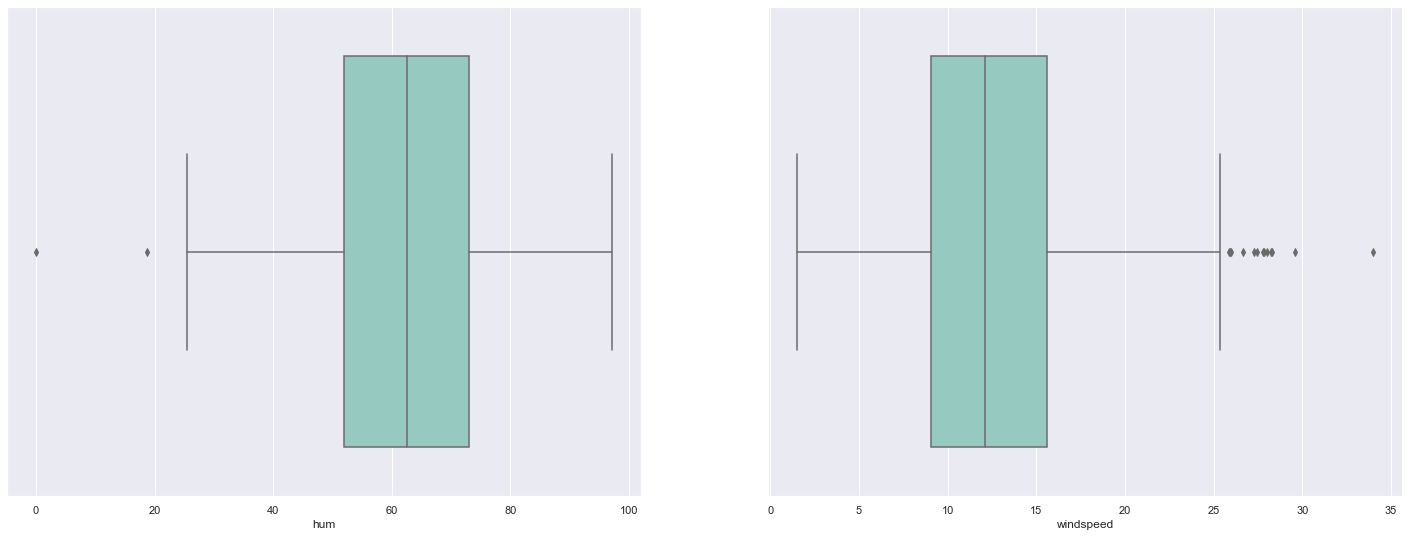

In [21]:
# Compare these columns with their Boxplots
sns.set(rc={'figure.figsize':(25,9)})

fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

sns.set_style("darkgrid")

ax = sns.boxplot(x=bikedf["hum"], ax=axes[0], palette="Set3")
ax = sns.boxplot(x=bikedf["windspeed"], ax=axes[1], palette="Set3")

# Show the plot.
plt.show()

In [22]:
# Method definition to remove outliers. This uses z-scores. Any value above +/- 3 std dev are outliers and hence we remove them.
def remove_outliers(df, col):
   
    # Remove outliers from the column
    
    return df[np.abs(stats.zscore(df[col])) < 3]

In [23]:
# Remove outlier from columns: 
# 'hum', 'windspeed', 'casual'


bikedf = remove_outliers(bikedf, 'hum')
bikedf = remove_outliers(bikedf, 'windspeed')

# Check the new shape. Only few observations are removed with outlier analysis
bikedf.shape

(725, 12)

### Create Dummy variables for categorical variables

In [24]:
def createDummyVariables(df, col):
    status = pd.get_dummies(df[col], drop_first = True)
    # Add the results to the original dataframe
    df = pd.concat([df, status], axis = 1)
    df.drop([col], axis = 1, inplace = True)
    return df    

In [25]:
bikedf = createDummyVariables(bikedf, 'weekday')
bikedf = createDummyVariables(bikedf, 'season')
bikedf = createDummyVariables(bikedf, 'weathersit')
bikedf = createDummyVariables(bikedf, 'mnth')

bikedf.sample(10)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Mon,Sat,Sun,Thurs,Tues,Wed,spring,summer,winter,light_snow_rain,misty,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
556,1,0,1,29.383347,32.51355,63.3333,10.166111,7264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
12,0,0,1,6.765000,7.54415,47.0417,20.167000,1406,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
563,1,0,1,32.526653,37.27915,57.7083,9.208614,5713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
659,1,0,1,19.987500,24.14710,56.8333,5.459381,7058,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
79,0,0,1,17.647835,20.48675,73.7391,19.348461,2077,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
592,1,0,1,29.485847,32.73440,51.9167,9.500332,7605,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
41,0,0,1,7.752731,10.67545,50.6364,7.272850,1746,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
576,1,0,1,29.246653,33.14480,70.4167,11.083475,7216,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
320,0,0,1,14.008347,16.16105,57.5833,20.459254,3053,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
137,0,0,1,22.550000,26.35790,87.0000,13.499964,3855,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [26]:
bikedf.columns # inspecting the columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'Mon', 'Sat', 'Sun', 'Thurs', 'Tues', 'Wed', 'spring', 'summer',
       'winter', 'light_snow_rain', 'misty', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul',
       'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

### Splitting the Data into Training and Testing Sets 

In [27]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(bikedf, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features
We will use MinMax scaling.

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [29]:
# Apply scaler() to all the columns except to binary and 'dummy' variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head() # inspecting the dataframe

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Mon,Sat,Sun,Thurs,Tues,Wed,spring,summer,winter,light_snow_rain,misty,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
642,1,0,1,0.692641,0.670569,0.519721,0.171647,0.932633,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
728,1,0,0,0.245101,0.204242,0.319025,0.826667,0.164795,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
479,1,0,1,0.520271,0.523547,0.241879,0.204993,0.696004,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
113,0,0,0,0.651106,0.632534,0.774941,0.401664,0.453942,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
685,1,0,0,0.331287,0.330942,0.405453,0.368308,0.627550,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


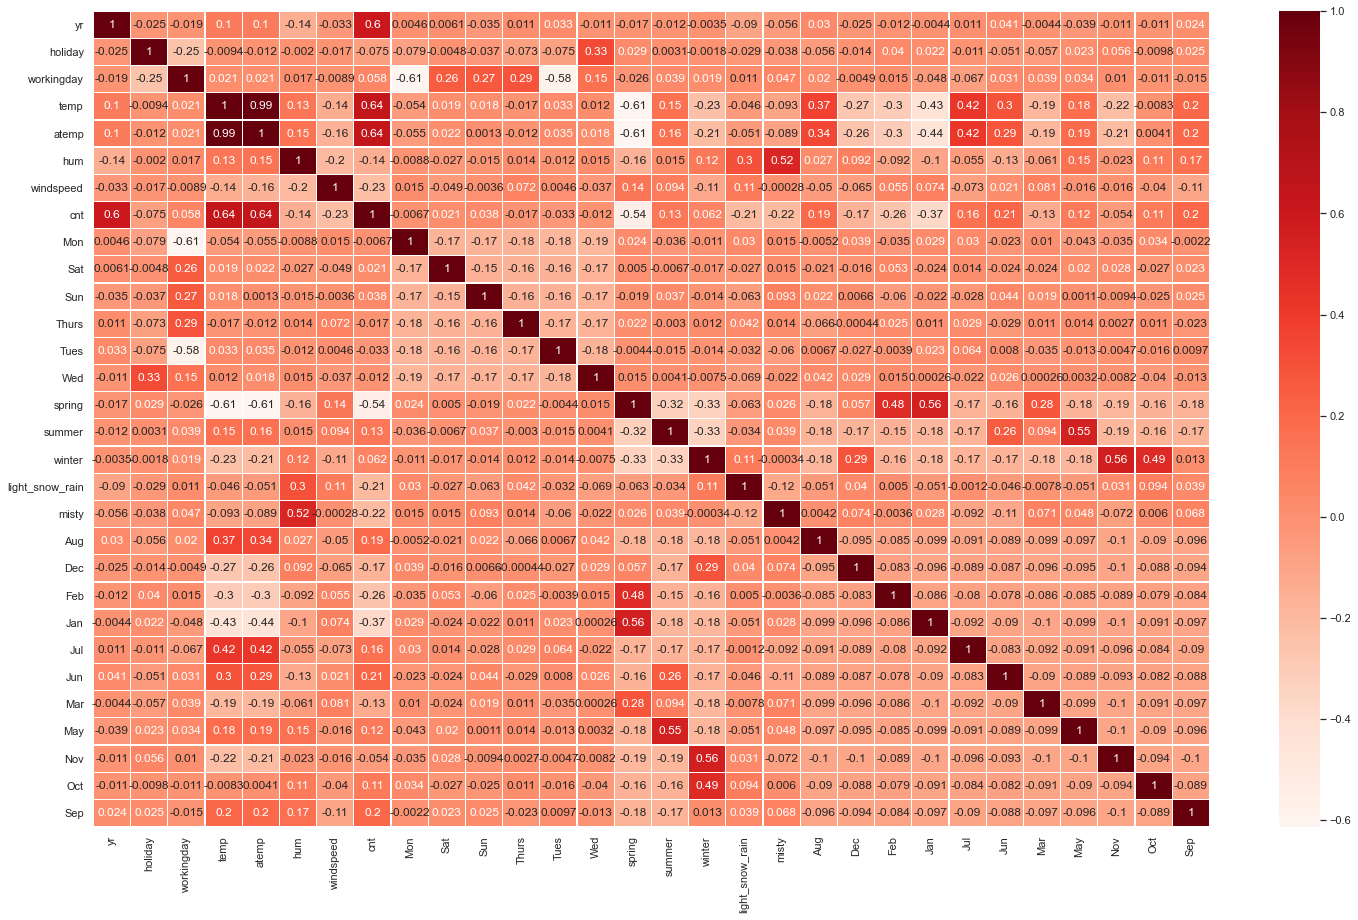

In [30]:
# Let's check the correlation coefficients to see which variables are highly correlated
fig, ax = plt.subplots(figsize = (25, 15))
sns.heatmap(df_train.corr(method ='pearson'), cmap ='Reds', linewidths = 0.30, annot = True)
plt.show()

In [31]:
df_train.corr(method ='pearson')

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Mon,Sat,Sun,Thurs,Tues,Wed,spring,summer,winter,light_snow_rain,misty,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
yr,1.000000,-0.025059,-0.019186,0.101430,0.102284,-0.143956,-0.033260,0.597993,0.004649,0.006142,-0.034512,0.011481,0.033139,-0.011339,-0.017035,-0.012417,-0.003537,-0.089598,-0.055631,0.030371,-0.025444,-0.011541,-0.004362,0.010594,0.041018,-0.004362,-0.038990,-0.011192,-0.011389,0.023771
holiday,-0.025059,1.000000,-0.250824,-0.009410,-0.012482,-0.002010,-0.016977,-0.074512,-0.079292,-0.004832,-0.037126,-0.072846,-0.075216,0.332279,0.028526,0.003115,-0.001839,-0.029284,-0.037533,-0.056338,-0.014457,0.039852,0.021538,-0.010979,-0.051384,-0.057023,0.023005,0.055505,-0.009771,0.024504
workingday,-0.019186,-0.250824,1.000000,0.020906,0.021255,0.016751,-0.008942,0.057628,-0.610327,0.258836,0.268557,0.290426,-0.578947,0.153865,-0.026019,0.038533,0.019273,0.011473,0.047095,0.019821,-0.004889,0.015471,-0.047851,-0.067146,0.031069,0.039052,0.034449,0.010136,-0.010808,-0.014573
temp,0.101430,-0.009410,0.020906,1.000000,0.989470,0.133941,-0.135345,0.639062,-0.053826,0.019191,0.017879,-0.016511,0.032538,0.012345,-0.607332,0.150455,-0.233508,-0.046399,-0.092540,0.368642,-0.267088,-0.297872,-0.433209,0.422357,0.296007,-0.187635,0.180396,-0.223149,-0.008268,0.200883
atemp,0.102284,-0.012482,0.021255,0.989470,1.000000,0.147594,-0.162400,0.644288,-0.055030,0.022110,0.001271,-0.011520,0.034834,0.017779,-0.612147,0.159715,-0.210272,-0.050591,-0.088787,0.340193,-0.257020,-0.298594,-0.439187,0.418148,0.287454,-0.187601,0.186927,-0.210779,0.004110,0.198557
hum,-0.143956,-0.002010,0.016751,0.133941,0.147594,1.000000,-0.201878,-0.143156,-0.008846,-0.026851,-0.014580,0.013553,-0.012205,0.015363,-0.164043,0.015452,0.119699,0.303456,0.516265,0.026986,0.092305,-0.092271,-0.101466,-0.054800,-0.130258,-0.061369,0.150777,-0.023483,0.107030,0.168296
windspeed,-0.033260,-0.016977,-0.008942,-0.135345,-0.162400,-0.201878,1.000000,-0.226754,0.015167,-0.049081,-0.003636,0.072469,0.004570,-0.037124,0.136897,0.094475,-0.112217,0.106780,-0.000284,-0.049746,-0.065016,0.055417,0.074363,-0.072745,0.020830,0.081026,-0.016488,-0.016255,-0.039659,-0.107087
cnt,0.597993,-0.074512,0.057628,0.639062,0.644288,-0.143156,-0.226754,1.000000,-0.006718,0.021032,0.038499,-0.016514,-0.033301,-0.012118,-0.544777,0.128891,0.062090,-0.206528,-0.215250,0.192681,-0.169133,-0.257609,-0.371855,0.156867,0.212110,-0.132385,0.115727,-0.053828,0.106840,0.204051
Mon,0.004649,-0.079292,-0.610327,-0.053826,-0.055030,-0.008846,0.015167,-0.006718,1.000000,-0.172876,-0.171405,-0.177255,-0.183021,-0.185876,0.024236,-0.036159,-0.010625,0.030414,0.015426,-0.005238,0.039326,-0.035092,0.029097,0.030414,-0.023313,0.010447,-0.042909,-0.034899,0.034020,-0.002214
Sat,0.006142,-0.004832,0.258836,0.019191,0.022110,-0.026851,-0.049081,0.021032,-0.172876,1.000000,-0.153580,-0.158821,-0.163988,-0.166546,0.004966,-0.006711,-0.017299,-0.027228,0.015303,-0.021074,-0.015939,0.052641,-0.023569,0.013636,-0.024105,-0.023569,0.019629,0.027972,-0.026733,0.022587


In [32]:
# From the correlation matrix it can be seen temp and atemp are highly correlated.
# Hence dropping one of them
drop_man_cols = []
df_train.drop(['temp'], axis=1, inplace=True)
drop_man_cols.append('temp')
df_train.shape

(507, 29)

### Dividing into X and Y sets for the model building

In [33]:
y_train = df_train.pop('cnt')
X_train = df_train

## Building our model now...



#### First we build model with all the variables and see how it fits

In [34]:
import statsmodels.api as sm
X_train_Md1 = sm.add_constant(X_train)
X_train_Md1.head()

,const,yr,holiday,workingday,atemp,hum,windspeed,Mon,Sat,Sun,Thurs,Tues,Wed,spring,summer,winter,light_snow_rain,misty,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
642,1.0,1,0,1,0.670569,0.519721,0.171647,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
728,1.0,1,0,0,0.204242,0.319025,0.826667,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
479,1.0,1,0,1,0.523547,0.241879,0.204993,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
113,1.0,0,0,0,0.632534,0.774941,0.401664,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
685,1.0,1,0,0,0.330942,0.405453,0.368308,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [35]:
lm = sm.OLS(y_train, X_train_Md1).fit()   # Running the linear model

In [36]:
print (lm.summary()) # printing the summary of our Linear model having all the independant features

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     105.3
Date:                Tue, 04 May 2021   Prob (F-statistic):          2.36e-182
Time:                        23:00:15   Log-Likelihood:                 503.20
No. Observations:                 507   AIC:                            -950.4
Df Residuals:                     479   BIC:                            -832.0
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2185      0.035     

In [37]:
# Although here we see the R-squared value is good but we see from the other parameters from the summary 
# that this model can be improved. Like we see many features with high p-value, Also mark the second Note
# which is indicating of strong multicollinearity in the model. Hence we plan to go for Recursive feature elimination (RFE)
# to get some coarser model with lower number of features which might reduce the complexity of the model and 
# also fix collinearity problem.

#### Using the LinearRegression function from SciKit Learn for its compatibility with RFE (which is a utility from sklearn)

## RFE
#### Recursive feature elimination

In [38]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [39]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

# We take first 15 features with this automated feature reduction algorithm
rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [40]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Mon', True, 1),
 ('Sat', False, 9),
 ('Sun', False, 12),
 ('Thurs', False, 8),
 ('Tues', True, 1),
 ('Wed', False, 7),
 ('spring', True, 1),
 ('summer', False, 13),
 ('winter', True, 1),
 ('light_snow_rain', True, 1),
 ('misty', True, 1),
 ('Aug', False, 14),
 ('Dec', True, 1),
 ('Feb', False, 5),
 ('Jan', False, 3),
 ('Jul', True, 1),
 ('Jun', False, 10),
 ('Mar', False, 11),
 ('May', False, 4),
 ('Nov', True, 1),
 ('Oct', False, 6),
 ('Sep', False, 2)]

In [41]:
col = X_train.columns[rfe.support_]
col # Features which RFE has selected for us

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'Mon',
       'Tues', 'spring', 'winter', 'light_snow_rain', 'misty', 'Dec', 'Jul',
       'Nov'],
      dtype='object')

In [42]:
dropped_rfe_cols = X_train.columns[~rfe.support_] # Features which RFE has rejected.
# We need these dropped features so that later the test data frame is treated in right way.

### Building model using statsmodel, with the features we have got from RFE

In [43]:
# Creating X_train dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [44]:
# Adding a constant variable and we build our first manual model
X_train_md3_1 = sm.add_constant(X_train_rfe)
X_train_md3_1.head()

,const,yr,holiday,workingday,atemp,hum,windspeed,Mon,Tues,spring,winter,light_snow_rain,misty,Dec,Jul,Nov
642,1.0,1,0,1,0.670569,0.519721,0.171647,0,0,0,1,0,0,0,0,0
728,1.0,1,0,0,0.204242,0.319025,0.826667,0,1,1,0,0,0,1,0,0
479,1.0,1,0,1,0.523547,0.241879,0.204993,0,0,0,0,0,0,0,0,0
113,1.0,0,0,0,0.632534,0.774941,0.401664,0,1,0,0,0,1,0,0,0
685,1.0,1,0,0,0.330942,0.405453,0.368308,1,0,0,1,0,0,0,0,1


In [45]:
lm = sm.OLS(y_train,X_train_md3_1).fit()   # Running the linear model

In [46]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     193.7
Date:                Tue, 04 May 2021   Prob (F-statistic):          8.10e-190
Time:                        23:00:17   Log-Likelihood:                 487.24
No. Observations:                 507   AIC:                            -944.5
Df Residuals:                     492   BIC:                            -881.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2125      0.023     

In [47]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,29.55
6,Mon,7.73
7,Tues,7.54
3,atemp,3.28
8,spring,2.64
1,holiday,2.42
9,winter,2.31
4,hum,2.14
14,Nov,1.78
11,misty,1.76


In [48]:
# Now from the above results it still talks multicollinearity issue in the Model 
# Also from VIF dataframe we see there are some features with high VIF. This needs to be addressed.
# As we have studied we should remove feature one by one to study its impact on the model.
X_train_md3_1.shape

(507, 16)

In [49]:
# Feature 'holiday' has high p-value as well as highest VIF. Hence first eliminate it.
X_train_rfe.drop(['holiday'], axis=1, inplace = True)
drop_man_cols.append('holiday')
X_train_rfe.shape

(507, 14)

In [50]:
# build model 3 with removed feature
X_train_md3_2 = sm.add_constant(X_train_rfe)

lr_3 = sm.OLS(y_train, X_train_md3_2).fit()

In [51]:
# Print the summary of the model
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     193.7
Date:                Tue, 04 May 2021   Prob (F-statistic):          8.10e-190
Time:                        23:00:18   Log-Likelihood:                 487.24
No. Observations:                 507   AIC:                            -944.5
Df Residuals:                     492   BIC:                            -881.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2156      0.037     

In [52]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,16.54
3,hum,15.97
1,workingday,12.92
4,windspeed,4.85
5,Mon,3.82
6,Tues,3.73
8,winter,2.95
10,misty,2.69
7,spring,2.63
0,yr,2.14


In [53]:
# From the above summary we see the multicollinearity issue seems to have been addressed.
# Still there are some variables with high p-value and VIFs
# Removing Tues as it has high p-value and VIF closer to 5

In [54]:
X_train_rfe.drop(['Tues'], axis=1, inplace= True)
drop_man_cols.append('Tues')
X_train_rfe.shape

(507, 13)

In [55]:
# build model 3 with removed feature
X_train_md3_3 = sm.add_constant(X_train_rfe)

lr_4 = sm.OLS(y_train, X_train_md3_3).fit()

In [56]:
# Print the summary of the model
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     208.4
Date:                Tue, 04 May 2021   Prob (F-statistic):          1.08e-190
Time:                        23:00:20   Log-Likelihood:                 486.54
No. Observations:                 507   AIC:                            -945.1
Df Residuals:                     493   BIC:                            -885.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2408      0.029     

In [57]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,15.18
2,atemp,13.60
4,windspeed,4.34
1,workingday,4.25
7,winter,2.83
9,misty,2.68
6,spring,2.25
0,yr,2.11
12,Nov,1.89
5,Mon,1.77


In [58]:
# Now we see the p-values of all the features are low showing their significance.
# But from VIF we still see high values of VIF indicating multicollinearity in the model.
# Hence dropping hum having high VIF
X_train_rfe.drop(['hum'], axis=1, inplace= True)
drop_man_cols.append('hum')
X_train_rfe.shape

(507, 12)

In [59]:
# build model 3 with removed feature
X_train_md3_4 = sm.add_constant(X_train_rfe)

lr_5 = sm.OLS(y_train, X_train_md3_4).fit()

In [60]:
# Print the summary of the model
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     213.9
Date:                Tue, 04 May 2021   Prob (F-statistic):          7.44e-187
Time:                        23:00:21   Log-Likelihood:                 474.62
No. Observations:                 507   AIC:                            -923.2
Df Residuals:                     494   BIC:                            -868.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1874      0.028     

In [61]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,6.23
3,windspeed,4.29
1,workingday,4.24
6,winter,2.66
0,yr,2.08
11,Nov,1.87
5,spring,1.82
4,Mon,1.76
8,misty,1.56
9,Dec,1.42


In [62]:
# Again p-values seem to be ok, but VIFs indicating multicollinearity in the model.
# But from EDA we have seen how demand is dependant on atemp and hence we do not want to drop it
# Instead we drop the next higher feature.
X_train_rfe.drop(['windspeed'], axis=1, inplace= True)
drop_man_cols.append('windspeed')
X_train_rfe.shape

(507, 11)

In [63]:
# build model with removed feature
X_train_md3_5 = sm.add_constant(X_train_rfe)

lr_6 = sm.OLS(y_train, X_train_md3_5).fit()

In [64]:
# Print the summary of the model
print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     223.0
Date:                Tue, 04 May 2021   Prob (F-statistic):          8.72e-184
Time:                        23:00:22   Log-Likelihood:                 464.53
No. Observations:                 507   AIC:                            -905.1
Df Residuals:                     495   BIC:                            -854.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1334      0.026     

In [65]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,5.06
1,workingday,4.13
5,winter,2.65
0,yr,2.08
10,Nov,1.85
3,Mon,1.73
4,spring,1.55
7,misty,1.55
8,Dec,1.42
9,Jul,1.32


In [66]:
# The VIFs are coming closer to 5. Again we drop workingday. Also the values of Rsquared are in good range.
X_train_rfe.drop(['workingday'], axis=1, inplace= True)
drop_man_cols.append('workingday')
X_train_rfe.shape

(507, 10)

In [67]:
# build model with removed feature
X_train_md3_6 = sm.add_constant(X_train_rfe)

lr_7 = sm.OLS(y_train, X_train_md3_6).fit()

In [68]:
# Print the summary of the model
print(lr_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     230.9
Date:                Tue, 04 May 2021   Prob (F-statistic):          1.81e-179
Time:                        23:00:23   Log-Likelihood:                 451.49
No. Observations:                 507   AIC:                            -881.0
Df Residuals:                     496   BIC:                            -834.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1799      0.025     

In [69]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,atemp,2.88
4,winter,2.60
0,yr,2.08
9,Nov,1.84
6,misty,1.52
7,Dec,1.41
3,spring,1.31
8,Jul,1.30
2,Mon,1.18
5,light_snow_rain,1.06


In [70]:
# With the above feature reduction we can see the VIF are now in good shape. But we see one variable with higher p-value
# We get rid of it.
X_train_rfe.drop(['Mon'], axis=1, inplace= True)
drop_man_cols.append('Mon')
X_train_rfe.shape

(507, 9)

In [71]:
# build model with removed feature
X_train_md3_7 = sm.add_constant(X_train_rfe)

lr_8 = sm.OLS(y_train, X_train_md3_7).fit()

In [72]:
# Print the summary of the model
print(lr_8.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     255.3
Date:                Tue, 04 May 2021   Prob (F-statistic):          4.77e-180
Time:                        23:00:23   Log-Likelihood:                 449.98
No. Observations:                 507   AIC:                            -880.0
Df Residuals:                     497   BIC:                            -837.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1860      0.024     

In [73]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,atemp,2.82
3,winter,2.59
0,yr,2.07
8,Nov,1.84
5,misty,1.51
6,Dec,1.41
7,Jul,1.30
2,spring,1.29
4,light_snow_rain,1.05


##### With the above feature reductions we can see finally we have a model with 9 features.
##### R squared value at 0.822 and Adjusted R Squared at 0.819. 
##### The F-statistic probability is also very low almost 0.
##### The p-values for all the selected features is 0. 
##### This seem to be reasonable model to go for further analysis.

In [74]:
# Now lets predict the target variable values for the train data 
y_train_pred = lr_8.predict(X_train_md3_7)
y_train_pred # Just for inspecting

642    0.842370
728    0.325835
479    0.681931
113    0.402038
685    0.585898
         ...   
583    0.741348
54     0.095906
353    0.327946
81     0.265543
525    0.805260
Length: 507, dtype: float64

### Residual analysis

In [75]:
# For using the above model we should ensure we do residual analysis which checks whether the assumptions 
# of Linear Regression are satisfied or not.
# Finding residual which is difference between actual y - predicted y
y_train_pred = lr_8.predict(X_train_md3_7)
res = y_train - y_train_pred

Text(0.5, 0, 'Errors')

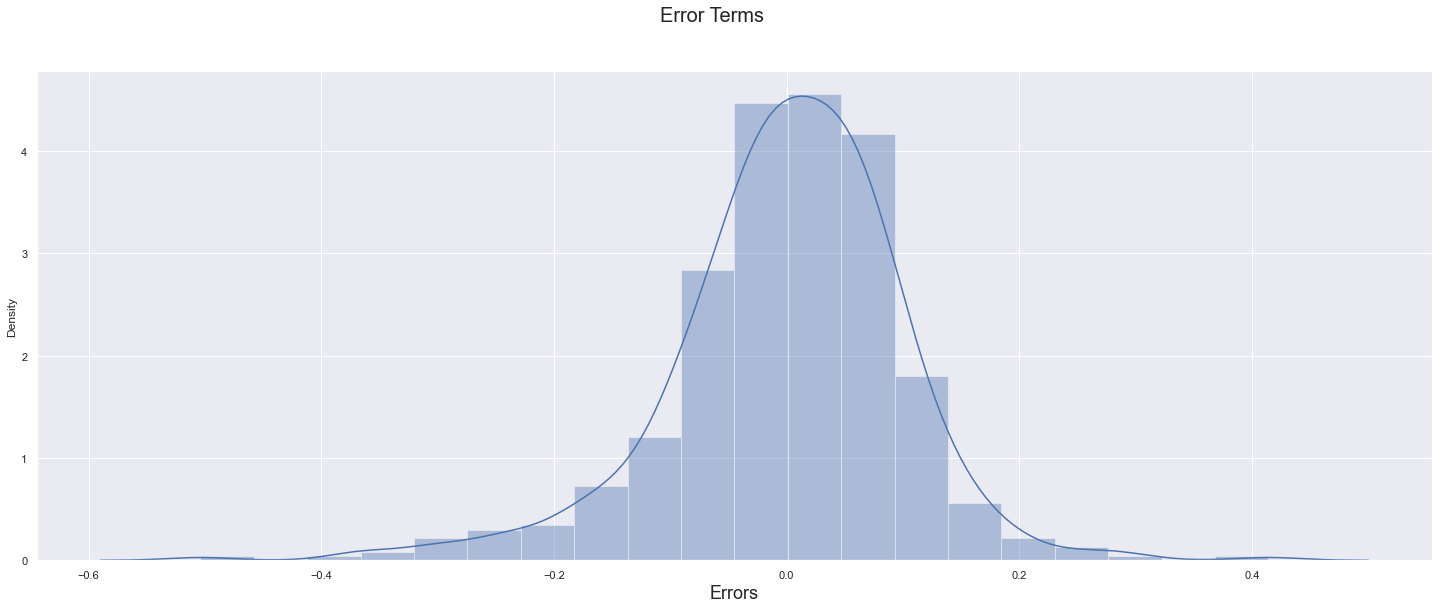

In [76]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot(res, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
# From the distribution plot below we can see that the error terms/ residuals are normally distributed.

Text(0, 0.5, 'residual')

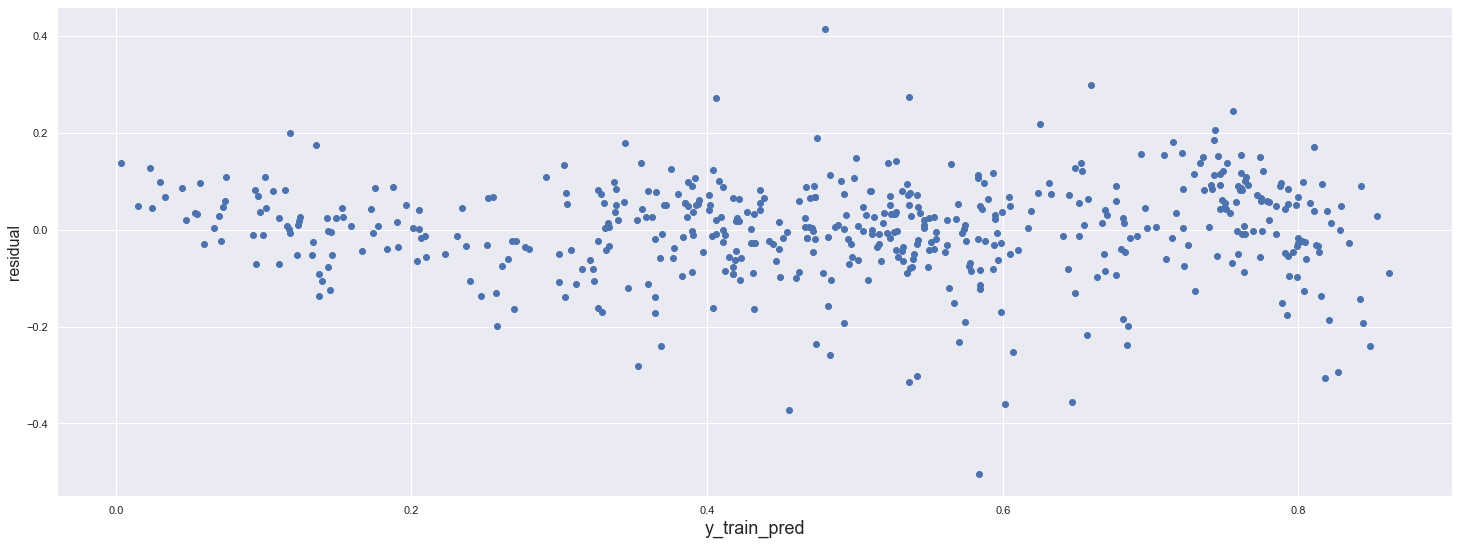

In [77]:
plt.scatter(y_train_pred, res)
fig.suptitle('residual vs y_train_pred', fontsize = 20)      # Plot heading 
plt.xlabel('y_train_pred', fontsize = 18)                          # X-label
plt.ylabel('residual', fontsize = 16)

# We plot the residual VS the y_predicted and see that the error or residual values are almost lying in 
# a band between -0.2 to 0.2. Hence it is not showing any variance in their values. Mostly const standard deviation.
# This is Homoscedasticity property of residuals

# Also we do not see any trend in errors/ residuals as they are scattered which means they are independant of each other

# These requirements of Linear Regression are satisfied with this model

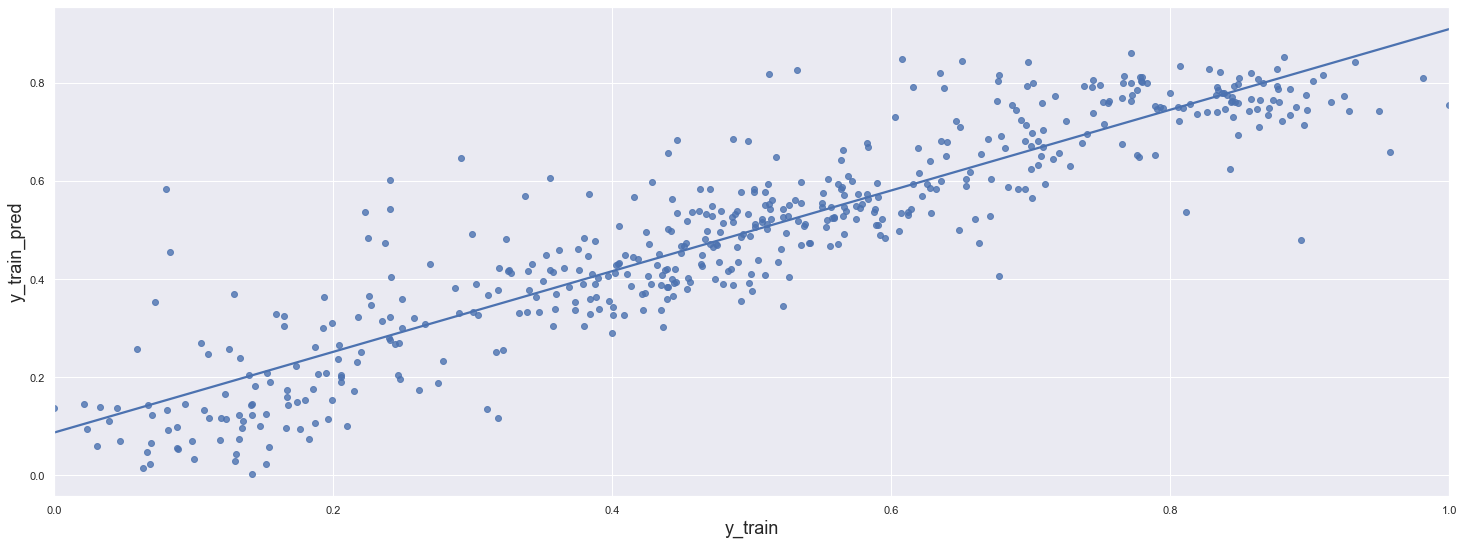

In [78]:
#fig, ax = plt.subplots(figsize = (25, 15))
sns.regplot(x = y_train, y = y_train_pred, ci = None)
fig.suptitle('Predicted y Vs Actual y', fontsize = 20)  
plt.xlabel('y_train', fontsize = 18)  
plt.ylabel('y_train_pred', fontsize = 18)
plt.show()

# Predicted target variable value VS Actual target variable linear relationship.

### Prepare Test data

In [79]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [80]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Mon,Sat,Sun,Thurs,Tues,Wed,spring,summer,winter,light_snow_rain,misty,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.00000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,0.486239,0.022936,0.743119,0.559558,0.545490,0.512211,0.389003,0.496373,0.096330,0.151376,0.169725,0.151376,0.137615,0.12844,0.238532,0.279817,0.220183,0.032110,0.316514,0.077982,0.087156,0.087156,0.073394,0.100917,0.100917,0.064220,0.077982,0.050459,0.100917,0.073394
std,0.500961,0.150043,0.437919,0.234907,0.224852,0.190215,0.206324,0.226559,0.295723,0.359240,0.376255,0.359240,0.345288,0.33535,0.427167,0.449942,0.415324,0.176698,0.466186,0.268760,0.282713,0.282713,0.261383,0.301913,0.301913,0.245709,0.268760,0.219393,0.301913,0.261383
min,0.000000,0.000000,0.000000,0.046591,0.026455,0.030161,-0.053367,-0.049378,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.360361,0.365473,0.364559,0.243305,0.337740,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.574785,0.575514,0.513341,0.349135,0.505191,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.774412,0.743429,0.652294,0.511217,0.653266,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,1.019437,0.954151,1.006644,0.961487,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
print(drop_man_cols)

['temp', 'holiday', 'Tues', 'hum', 'windspeed', 'workingday', 'Mon']


In [82]:
print(dropped_rfe_cols)

Index(['Sat', 'Sun', 'Thurs', 'Wed', 'summer', 'Aug', 'Feb', 'Jan', 'Jun',
       'Mar', 'May', 'Oct', 'Sep'],
      dtype='object')


In [83]:
y_test = df_test.pop('cnt')
X_test = df_test
X_test.shape

(218, 29)

In [84]:
# Adding constant variable to test dataframe
X_test_md3 = sm.add_constant(X_test)

In [85]:
# Creating X_test_md3 dataframe by dropping variables we dropped from training data
X_test_md3 = X_test_md3.drop(dropped_rfe_cols, axis = 1)
X_test_md3 = X_test_md3.drop(drop_man_cols, axis = 1)
X_test_md3.shape

(218, 10)

In [86]:
# Making predictions using the final model
y_test_pred_md3 = lr_8.predict(X_test_md3)

### Model Evaluation

Text(0, 0.5, 'y_pred')

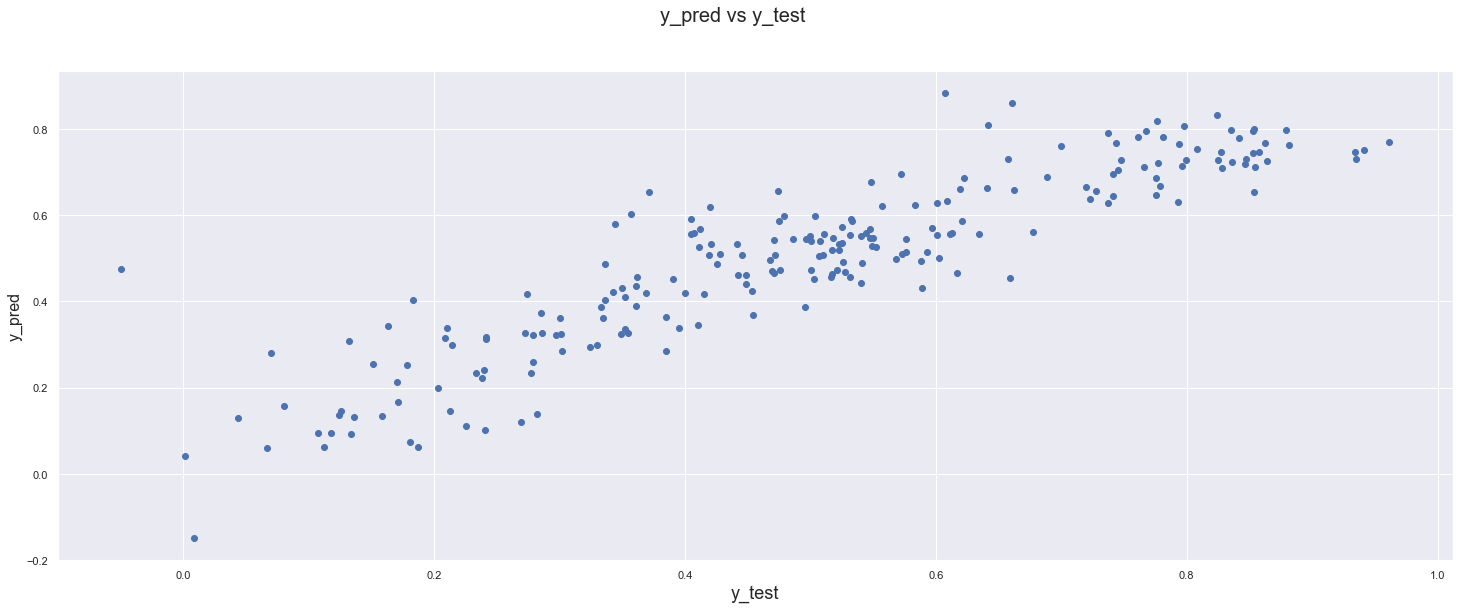

In [87]:
# Plotting y_test and y_pred for the test data to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_test_pred_md3)
fig.suptitle('y_pred vs y_test', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16) 

In [88]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred_md3)
# The r2 score with the test data is close to the final models R-squared value which is 0.822

0.8033401146219619

The equation of our best fitted line is:

$ cnt = 0.186 + 0.246  \times  yr + 0.477  \times  atemp - 0.1385 \times spring + 0.09 \times winter - 0.28 \times lightsnowrain - 0.0857 \times misty - 0.0653 \times Dec - 0.0686 \times Jul - 0.0945 \times Nov $